In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: True


In [2]:
!pip install torchinfo lightning pytorch-lightning ray[tune] robust_downloader dask[dataframe] nvidia-cudnn-cu11==8.6.0.163

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.v2 import functional as TF

In [4]:
import torchmetrics
import torchvision.models as models
import lightning as L
from lightning.pytorch import Trainer
from ray.air import ScalingConfig, RunConfig, CheckpointConfig
from ray.train.huggingface.transformers import prepare_trainer
from ray.train.lightning import RayDDPStrategy, RayLightningEnvironment, RayTrainReportCallback
from ray.tune.integration.pytorch_lightning import TuneReportCheckpointCallback
from ray.train.torch import TorchTrainer
from ray.tune import choice, loguniform, uniform, Tuner, TuneConfig
from ray.tune.schedulers import ASHAScheduler
import matplotlib

In [5]:
import os
from pathlib import Path
import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
L.seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [7]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Lego Brick Detector

Find the type of a Lego brick from a foto. Bricks are identified by a number and a color.
Considering only the number in this project.

## Workflow

### Dataset

* download and unzip
* exploratoy data analysis
* reducing data set

### Model

* trying simpler variants
  * only binary classification (2 classes)
  * a handful of classes
  * resnet18
  * quick model with [fast.ai](fast.ai)
* experiment tracking with tensorboard
* final model with pytorch and lightning

### Tuning

* hyperparameter tuning with ray
* analysis of checkpoints


In [8]:
if IN_COLAB:
    import shutil
    shutil.copy("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/utils.py", ".",)
    shutil.copy("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/part_names.json", ".",)

import utils
from importlib import reload
reload(utils)
from utils import DataSetModule, ImageFolder, create_train_test_split, download_and_unpack, load_ds_cached

In [9]:
if IN_COLAB:
    SCRIPT_DIR = Path("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt")
else:
  SCRIPT_DIR = Path(os.getcwd())
SCRIPT_DIR

PosixPath('/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt')

In [10]:
DATA_BASE_PATH = SCRIPT_DIR / "data"

## Download And Unpack Data

Data set: lego-bricks-for-training-classification-network
Can be downloaded from: [https://mostwiedzy.pl/en/open-research-data](https://mostwiedzy.pl/en/open-research-data/lego-bricks-for-training-classification-network,202309140842198941751-0)

In [11]:
#!ls {DATA_BASE_PATH}/data_set/photos

In [12]:
#os.listdir(DATA_BASE_PATH / "data_set" / "photos")

Downloading and unpacking (using robust_downloader)

In [13]:
# unpack only subset of the data (for reproducibility reasons listed here explicitly):
used_classes = ['32291',
 '40902',
 '32449',
 '18649',
 '17485',
 '17114',
 '15332',
 '2456',
 '6182',
 '32348',
 '15397',
 '32523',
 '90609',
 '22385',
 '32015',
 '32526',
 '60477',
 '32557',
 '6215',
 '60476',
 '32316',
 '40490',
 '2357',
 '32828',
 '15254',
 '3795',
 '18653',
 '3004',
 '20482',
 '32529',
 '24299',
 '18674',
 '15100']

used_classes = [f"photos/{cl}" for cl in used_classes]

In [14]:
url = "https://mostwiedzy.pl/en/open-research-data/lego-bricks-for-training-classification-network,202309140842198941751-0/download/"
filename = "file 05 - dataset.zip"
DATA_SET_PATH = download_and_unpack(url, filename, DATA_BASE_PATH, files_to_unzip=used_classes)

In [15]:
DATA_SET_PATH

PosixPath('/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/data/data_set')

In [16]:
zipfile_size = os.path.getsize(DATA_BASE_PATH / "download" / filename)
f"The dataset is huge: {zipfile_size:_} bytes".replace("_", " ")


'The dataset is huge: 6 469 779 381 bytes'

In [17]:
file_size_kb = zipfile_size / 1024
file_size_mb = file_size_kb / 1024
file_size_gb = file_size_mb / 1024

print(f"About {file_size_gb:.2f} Gb of data (compressed)")

About 6.03 Gb of data (compressed)


In [18]:
#DATA_PATHS = [DATA_SET_PATH / "photos",
#              DATA_SET_PATH / "renders"]
# only using (some) photos
DATA_PATHS = [DATA_SET_PATH / "photos"]


# Data Set Structure

The dataset consist of two parts:
1. Photos
2. Renders (synthetic data)

The images are grouped in folders that are named after the Lego part number.

In [50]:
# tree {DATA_BASE_PATH}
# .
# ├── photos
# │   ├── 10197
# │   │   ├── c0_0_Con31_YGzI_original_1618300443534.jpg
# │   │   ├── c0_1_Con31_9CX6_original_1618300433289.jpg
# │   │   └── ...
# │   ├── 10201
# │   │   ├── c0_1_P53_15Jj_original_1618573176305.jpg
# │   │   ├── c0_1_P53_5CHe_original_1618573183733.jpg
# │   │   └── ...
# │   :
# │
# └── renders
#     ├── 10197
#     │   ├── 10197_Aqua_0_1621079008.jpeg
#     │   ├── 10197_Aqua_1_1621079011.jpeg
#     │   └── ...
#     ├── 11090
#     │   ├── 11090_Aqua_0_1619137894.jpeg
#     │   ├── 11090_Aqua_0_1619194611.jpeg
#     │   └── ...
#     :

## Label Names

Numbers are hard to memorize. Translate the number in a description. The description was taken from the [Rebrickable API](https://rebrickable.com/).

In [20]:
with open("part_names.json") as part_names_f :
  pn = json.load(part_names_f)
  pn = json.dumps(pn, indent=2)
  print(pn[:1000], "...")


{
  "10197": "Technic Pin Connector Hub with 2 Perpendicular Axles",
  "10201": "Bracket 1 x 2 - 1 x 4 [Rounded Corners]",
  "10288": "Technic Axle and Pin Connector Triple [120\u00b0 Offset]",
  "10314": "Brick Curved 1 x 4 x 1 1/3 No Studs, Curved Top with Raised Inside Support",
  "10928": "Technic Gear 8 Tooth [Reinforced]",
  "11090": "Bar Holder with Clip",
  "11153": "Slope Curved 4 x 1 No Studs [Stud Holder with Symmetric Ridges]",
  "11211": "Brick Special 1 x 2 with 2 Studs on 1 Side",
  "11212": "Plate 3 x 3",
  "11213": "Plate Round 6 x 6 with Hole",
  "11214": "Technic Axle Pin 3L with Friction Ridges Lengthwise and 1L Axle",
  "11215": "Bracket 5 x 2 x 1 1/3 with Holes, Pin Bottom",
  "11272": "Technic Axle Connector 2 x 3 Quadruple",
  "11458": "Plate Special 1 x 2 with Pin Hole on Top",
  "11476": "Plate Special 1 x 2 with Clip Horizontal on Side",
  "11477": "Slope Curved 2 x 1 No Studs [1/2 Bow]",
  "11478": "Technic Beam 1 x 5 Thin with Axle Holes on Ends",
  "13349"

In [21]:
ds = load_ds_cached(DATA_PATHS, max_images_per_folder=200, clear_cache=True, verify=False)
num_classes = len(ds.classes)

Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 Bent (4 - 4) Thick', 'Techni

In [22]:
num_classes, len(ds)

(33, 4036)

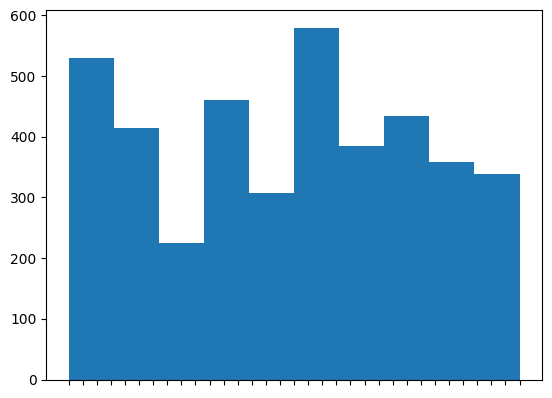

<Figure size 640x480 with 0 Axes>

In [23]:

from importlib import reload
reload(utils)
from utils import *
plt = utils.labels_hist(ds.observations)
plt.savefig("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/labels_hist.png")

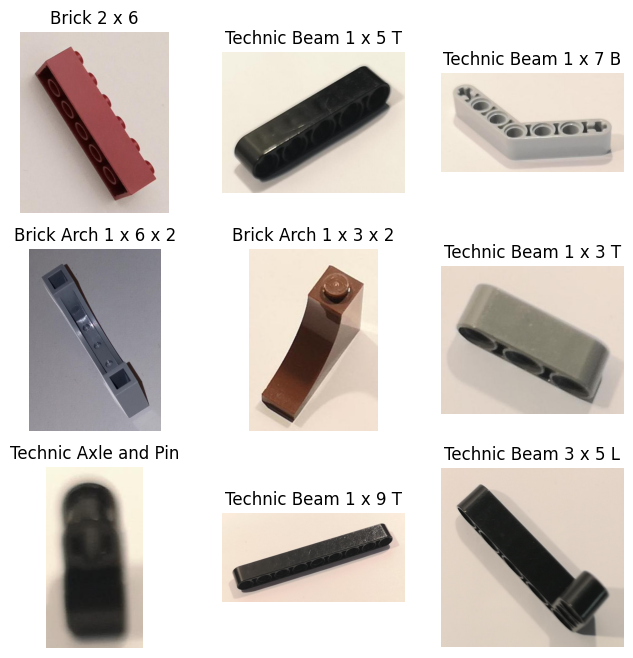

<Figure size 640x480 with 0 Axes>

In [24]:
from utils import plot_random_image_grid

plt = plot_random_image_grid(ds)
plt.savefig("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/random_image_grid.png")

## Data Loader

Load data in batches and create train, validation and test splits.

In [25]:
def load_data(ds, tr_train, tr_val, batch_size=64):
    all_ids = [i for i in range(0, len(ds.observations))]
    all_labels = [x["label"] for x in ds.observations]

    train_ids, val_ids, test_ids = create_train_test_split(
        all_ids, all_labels, random_state=123, test_size=0.2, val_size=0.1
    )


    ds_train = ImageFolder.from_subset(ds, train_ids)
    ds_val = ImageFolder.from_subset(ds, val_ids)
    ds_test = ImageFolder.from_subset(ds, test_ids)

    dm = DataSetModule(
        ds_train=ds_train,
        ds_val=ds_val,
        ds_test=ds_test,
        classes=ds.classes,
        train_transform=tr_train,
        test_transform=tr_val,
        batch_size=batch_size,
    )
    return dm

# Model

Use a pretrained resnext50 model with some basic transforms.

In [26]:
def get_resnext50_model_and_transforms(num_classes, additional_train_transforms=None):
    net = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
    net.fc = nn.Sequential(nn.Linear(2048, num_classes))

    common_transforms = transforms.Compose([
            transforms.RandomResizedCrop(128),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    if additional_train_transforms is not None:
        tr_train = transforms.Compose([
            additional_train_transforms,
            common_transforms
        ]
        )
    else:
        tr_train = common_transforms

    tr_val = common_transforms

    return net, tr_train, tr_val


# Classifier

Create a clasifier with the model, loss functions, metrics and optimizer.

In [27]:
model, _, _ = get_resnext50_model_and_transforms(num_classes)
class Classifier(L.LightningModule):
    def __init__(self, model=model, num_classes=num_classes, learning_rate=0.001, weight_decay: float = 0.0):
        super().__init__()
        self.model = model

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.loss_fn = nn.CrossEntropyLoss()

        # Accuracy
        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

        # Loss
        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()
        self.test_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update all metrics
        self.train_loss.update(loss)
        self.train_accuracy.update(preds, y)

        # Log metrics for bartch
        self.log("train/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)

        self.log(
            "train/acc_step",
            self.train_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_train_epoch_end(self):
        # Log average loss and metrics for the entire epoch
        avg_loss = self.train_loss.compute()
        avg_accuracy = self.train_accuracy.compute()

        self.log("train/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("train/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True)

        # Reset metrics for the next epoch
        self.train_loss.reset()
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update metrics
        self.val_loss.update(loss)
        self.val_accuracy.update(preds, y)

        # Log metrics for this batch
        self.log("val/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)
        self.log(
            "val/accuracy_step",
            self.val_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_validation_epoch_end(self):
        # Log average loss and metrics for the entire validation epoch
        avg_loss = self.val_loss.compute()
        avg_accuracy = self.val_accuracy.compute()

        self.log("val/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("val/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True, sync_dist=True)

        # Reset metrics for the next epoch
        self.val_loss.reset()
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self.model(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update metrics
        self.test_loss.update(loss)
        self.test_accuracy.update(preds, y)

        # Log metrics for this batch
        self.log("test/loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)
        self.log(
            "test/accuracy_step",
            self.test_accuracy,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )

        return loss

    def on_test_epoch_end(self):
        # Log average loss and metrics for the entire validation epoch
        avg_loss = self.test_loss.compute()
        avg_accuracy = self.test_accuracy.compute()

        self.log("test/loss_epoch", avg_loss, prog_bar=True, on_epoch=True)
        self.log("test/accuracy_epoch", avg_accuracy, prog_bar=True, on_epoch=True, sync_dist=True)

        # Reset metrics for the next epoch
        self.test_loss.reset()
        self.test_accuracy.reset()


    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), self.learning_rate, weight_decay=self.weight_decay
        )

# Augmentations

Define some augmentation for use during hyperparameter tuning.

In [28]:
complex_transforms_0 = transforms.Compose(
    [
        transforms.RandomRotation(12),
        transforms.RandomResizedCrop(150),
        transforms.ColorJitter(brightness=0.2, contrast=0.25, saturation=0.2, hue=0.1),
    ])

complex_transforms_1 = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.45, contrast=0.5, saturation=0.5, hue=0.2)],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.25),
    ])

all_additional_transforms = {
    "None": None,
    "complex_transforms_0": complex_transforms_0,
    "complex_transforms_1": complex_transforms_1,
}

# Trainer and Training Loop

In [29]:
from lightning.pytorch.callbacks import ModelCheckpoint
def get_trainer():
  trainer = L.Trainer(
      devices="auto",
      accelerator="auto",
      precision="32",
      fast_dev_run=False,
      enable_checkpointing=True,
      log_every_n_steps=1,
      callbacks=[TuneReportCheckpointCallback(
          {"val/accuracy_epoch": "val/accuracy_epoch"},
          on="validation_end"),
                 TuneReportCheckpointCallback(
          {"test/accuracy_epoch": "test/accuracy_epoch"},
          on="test_end"),
                 ],
      plugins=[RayLightningEnvironment()],
  )
  trainer = prepare_trainer(trainer)
  return trainer

In [30]:
def training_loop(config):

    ds = ImageFolder(DATA_PATHS)

    num_classes = len(ds.classes)

    transform_name = config["additional_transforms"]
    additonal_transforms = all_additional_transforms[transform_name]
    model, tr_train, tr_val = get_resnext50_model_and_transforms(num_classes,
                                                               additional_train_transforms=additonal_transforms)

    dm = load_data(ds, tr_train, tr_val, config["batch_size"])

    model = Classifier(model, num_classes=num_classes,
                       learning_rate=config["learning_rate"],
                       weight_decay=config["weight_decay"])

    trainer = get_trainer()
    trainer.fit(model, datamodule=dm)


In [31]:
all_additional_transforms_names = [str(i) for i in all_additional_transforms.keys()]
all_additional_transforms_names

['None', 'complex_transforms_0', 'complex_transforms_1']

### Hyperparameter Tuning

In [32]:
# Reduced search space for demonstrantion reasons
search_space = {
    "additional_transforms": choice(['None']),
    "learning_rate": uniform(1e-5, 1e-3),
    "weight_decay": loguniform(1e-7, 1e-5),
    "batch_size": choice([64]),
}

In [33]:
# Reduced number of epochs and samples for demonstration reasons
max_epochs = 30
num_samples = 6

### Tuning

In [34]:
def tuner_and_trainer():
    scheduler = ASHAScheduler(max_t=max_epochs, grace_period=1, reduction_factor=2)

    scaling_config = ScalingConfig(
        num_workers=1, use_gpu=True, resources_per_worker={"CPU": 0, "GPU": 1}
    )

    run_config = RunConfig(
        checkpoint_config=CheckpointConfig(
            num_to_keep=2,
            checkpoint_score_attribute="val/accuracy_epoch",
            checkpoint_score_order="max",
        ),
    )

    ray_trainer = TorchTrainer(
        training_loop,
        scaling_config=scaling_config,
        run_config=run_config,
    )

    tuner = Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=TuneConfig(
            metric="val/accuracy_epoch",
            mode="max",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner, ray_trainer

In [35]:
tuner, trainer = tuner_and_trainer()

In [36]:
results = tuner.fit()

2024-11-30 18:29:45,680	INFO worker.py:1819 -- Started a local Ray instance.
2024-11-30 18:29:47,060	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+---------------------------------------------------------------------+
| Configuration for experiment     TorchTrainer_2024-11-30_18-29-44   |
+---------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator              |
| Scheduler                        AsyncHyperBandScheduler            |
| Number of trials                 6                                  |
+---------------------------------------------------------------------+

View detailed results here: /root/ray_results/TorchTrainer_2024-11-30_18-29-44
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-11-30_18-29-44_214767_11603/artifacts/2024-11-30_18-29-47/TorchTrainer_2024-11-30_18-29-44/driver_artifacts`

Trial status: 6 PENDING
Current time: 2024-11-30 18:29:47. Total running time: 0s
Logical resource usage: 0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------

(TrainTrainable pid=12563) 2024-11-30 18:29:53.745264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=12563) 2024-11-30 18:29:53.766955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=12563) 2024-11-30 18:29:53.773593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=12563) 2024-11-30 18:29:55.146797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_13c17_00000 started with configuration:
+-----------------------------------------------------------------+
| Trial TorchTrainer_13c17_00000 config                           |
+-----------------------------------------------------------------+
| train_loop_config/additional_transforms                    None |
| train_loop_config/batch_size                                 64 |
| train_loop_config/learning_rate           0.0003807947176588889 |
| train_loop_config/weight_decay            7.969454818643928e-06 |
+-----------------------------------------------------------------+


(RayTrainWorker pid=12666) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=12563) Started distributed worker processes: 
(TorchTrainer pid=12563) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=12666) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=12666) 2024-11-30 18:30:02.822531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=12666) 2024-11-30 18:30:02.842744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=12666) 2024-11-30 18:30:02.848767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 


Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:30:17. Total running time: 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_13c17_00000   RUNNING    None                                0.000380795              7.96945e-06                       64 |
| TorchTrainer_13c17_00001   PENDING    None                                0.000602672              2.05134e-07                       64 |
| TorchTrainer_13c17_00002   PENDING    None                                6.75028e-05              5.39948e-06                 

(RayTrainWorker pid=12666) GPU available: True (cuda), used: True
(RayTrainWorker pid=12666) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=12666) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=12666) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=12666) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(RayTrainWorker pid=12666) Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 B

(RayTrainWorker pid=12666) 
(RayTrainWorker pid=12666)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=12666) --------------------------------------------------------------
(RayTrainWorker pid=12666) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=12666) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=12666) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=12666) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=12666) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=12666) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=12666) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=12666) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=12666) --------------------------------------------------------------
(RayTrainWorker pid=12666) 23.0 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


(RayTrainWorker pid=12666) [rank0]:[W1130 18:30:29.970760653 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.
(RayTrainWorker pid=12666) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=12666) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices

                                                                           
Epoch 0:  38%|███▊      | 20/52 [00:16<00:26,  1.19it/s, v_num=0, train/loss_step=1.360]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:30:47. Total running time: 1min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_13c17_00000   RUNNING    None                                0.000380795              7.96945e-06                       64 |
| TorchTrainer_13c17_00001   PENDING    None                                0.000602672              

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)
(RayTrainWorker pid=12666) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=12666) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


(RayTrainWorker pid=12666) 
Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.486, val/loss_step=0.486, val/loss_epoch=0.599, val/accuracy_epoch=0.816]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:31:17. Total running time: 1min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.816216230392456 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+--------------------------

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000001)


(RayTrainWorker pid=12666) 
Epoch 2:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.548, val/loss_step=0.287, val/loss_epoch=0.475, val/accuracy_epoch=0.884, train/loss_epoch=1.500, train/accuracy_epoch=0.599]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:32:17. Total running time: 2min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.883783757686615 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s) 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000002)


(RayTrainWorker pid=12666) 
Epoch 3:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.467, val/loss_step=0.259, val/loss_epoch=0.321, val/accuracy_epoch=0.908, train/loss_epoch=0.447, train/accuracy_epoch=0.864]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:33:17. Total running time: 3min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.908108115196228 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s) 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000003)


(RayTrainWorker pid=12666) 
Epoch 4:  38%|███▊      | 20/52 [00:19<00:31,  1.01it/s, v_num=0, train/loss_step=0.191, val/loss_step=0.365, val/loss_epoch=0.303, val/accuracy_epoch=0.903, train/loss_epoch=0.271, train/accuracy_epoch=0.920]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:34:17. Total running time: 4min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9027026891708374 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000004)


(RayTrainWorker pid=12666) 
Epoch 5:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.323, val/loss_step=0.204, val/loss_epoch=0.256, val/accuracy_epoch=0.932, train/loss_epoch=0.271, train/accuracy_epoch=0.920]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:34:47. Total running time: 5min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9324324131011963 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s) 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000005)


(RayTrainWorker pid=12666) 
Epoch 6:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.112, val/loss_step=0.273, val/loss_epoch=0.182, val/accuracy_epoch=0.949, train/loss_epoch=0.245, train/accuracy_epoch=0.922]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:35:47. Total running time: 6min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9486486315727234 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s) 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000006)


(RayTrainWorker pid=12666) 
Epoch 7:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.217, val/loss_step=0.397, val/loss_epoch=0.529, val/accuracy_epoch=0.889, train/loss_epoch=0.209, train/accuracy_epoch=0.937]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:36:47. Total running time: 7min 0s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.8891891837120056 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000007)


(RayTrainWorker pid=12666) 
Epoch 7: 100%|██████████| 52/52 [00:51<00:00,  1.01it/s, v_num=0, train/loss_step=0.234, val/loss_step=0.220, val/loss_epoch=0.225, val/accuracy_epoch=0.927, train/loss_epoch=0.209, train/accuracy_epoch=0.937]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:37:17. Total running time: 7min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000008)


(RayTrainWorker pid=12666) 
Epoch 9:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.145, val/loss_step=0.234, val/loss_epoch=0.185, val/accuracy_epoch=0.943, train/loss_epoch=0.194, train/accuracy_epoch=0.940]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:38:17. Total running time: 8min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9432432651519775 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000009)


(RayTrainWorker pid=12666) 
                                                                      
Epoch 10:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.137, val/loss_step=0.250, val/loss_epoch=0.213, val/accuracy_epoch=0.924, train/loss_epoch=0.144, train/accuracy_epoch=0.955]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:39:18. Total running time: 9min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9243243336677551 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     .

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000010)


(RayTrainWorker pid=12666) 
Epoch 11:  38%|███▊      | 20/52 [00:19<00:31,  1.03it/s, v_num=0, train/loss_step=0.0864, val/loss_step=0.162, val/loss_epoch=0.144, val/accuracy_epoch=0.954, train/loss_epoch=0.152, train/accuracy_epoch=0.956]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:40:18. Total running time: 10min 30s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.954054057598114 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000011)


(RayTrainWorker pid=12666) 
Epoch 12:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0821, val/loss_step=0.141, val/loss_epoch=0.191, val/accuracy_epoch=0.943, train/loss_epoch=0.152, train/accuracy_epoch=0.956]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:40:48. Total running time: 11min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9432432651519775 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000012)


(RayTrainWorker pid=12666) 
Epoch 13:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.048, val/loss_step=0.242, val/loss_epoch=0.243, val/accuracy_epoch=0.930, train/loss_epoch=0.135, train/accuracy_epoch=0.958]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:41:48. Total running time: 12min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.929729700088501 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000013)


(RayTrainWorker pid=12666) 
Epoch 14:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.159, val/loss_step=0.224, val/loss_epoch=0.208, val/accuracy_epoch=0.938, train/loss_epoch=0.133, train/accuracy_epoch=0.960]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:42:48. Total running time: 13min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9378378391265869 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000014)


(RayTrainWorker pid=12666) 
Epoch 15:  38%|███▊      | 20/52 [00:19<00:31,  1.01it/s, v_num=0, train/loss_step=0.0844, val/loss_step=0.182, val/loss_epoch=0.206, val/accuracy_epoch=0.935, train/loss_epoch=0.148, train/accuracy_epoch=0.952]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:43:48. Total running time: 14min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9351351261138916 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000015)


(RayTrainWorker pid=12666) 
Epoch 16:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.280, val/loss_step=0.201, val/loss_epoch=0.162, val/accuracy_epoch=0.941, train/loss_epoch=0.148, train/accuracy_epoch=0.952]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:44:18. Total running time: 14min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9405405521392822 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000016)


(RayTrainWorker pid=12666) 
Epoch 17:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.101, val/loss_step=0.0767, val/loss_epoch=0.108, val/accuracy_epoch=0.968, train/loss_epoch=0.140, train/accuracy_epoch=0.957]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:45:18. Total running time: 15min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9675675630569458 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000017)


(RayTrainWorker pid=12666) 
Epoch 18:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.049, val/loss_step=0.0553, val/loss_epoch=0.166, val/accuracy_epoch=0.946, train/loss_epoch=0.114, train/accuracy_epoch=0.967] 
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:46:18. Total running time: 16min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9459459185600281 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     t

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000018)


(RayTrainWorker pid=12666) 
Epoch 19:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0694, val/loss_step=0.0441, val/loss_epoch=0.138, val/accuracy_epoch=0.949, train/loss_epoch=0.114, train/accuracy_epoch=0.967]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:46:48. Total running time: 17min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9486486315727234 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000019)


(RayTrainWorker pid=12666) 
Epoch 20:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0632, val/loss_step=0.294, val/loss_epoch=0.143, val/accuracy_epoch=0.957, train/loss_epoch=0.103, train/accuracy_epoch=0.971]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:47:48. Total running time: 18min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9567567706108093 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000020)


(RayTrainWorker pid=12666) 
Epoch 21:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.160, val/loss_step=0.172, val/loss_epoch=0.146, val/accuracy_epoch=0.943, train/loss_epoch=0.0997, train/accuracy_epoch=0.969]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:48:48. Total running time: 19min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9432432651519775 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000021)


(RayTrainWorker pid=12666) 
Epoch 22:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.0138, val/loss_step=0.261, val/loss_epoch=0.185, val/accuracy_epoch=0.938, train/loss_epoch=0.114, train/accuracy_epoch=0.962]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:49:48. Total running time: 20min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9378378391265869 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000022)


(RayTrainWorker pid=12666) 
Epoch 23:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.217, val/loss_step=0.134, val/loss_epoch=0.180, val/accuracy_epoch=0.943, train/loss_epoch=0.114, train/accuracy_epoch=0.962]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:50:18. Total running time: 20min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9432432651519775 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000023)


(RayTrainWorker pid=12666) 
Epoch 24:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0745, val/loss_step=0.280, val/loss_epoch=0.189, val/accuracy_epoch=0.935, train/loss_epoch=0.115, train/accuracy_epoch=0.965]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:51:18. Total running time: 21min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9351351261138916 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time 

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000024)


(RayTrainWorker pid=12666) 
Epoch 25:  38%|███▊      | 20/52 [00:19<00:31,  1.01it/s, v_num=0, train/loss_step=0.0847, val/loss_step=0.153, val/loss_epoch=0.0918, val/accuracy_epoch=0.970, train/loss_epoch=0.075, train/accuracy_epoch=0.977]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:52:18. Total running time: 22min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9702702760696411 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     t

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000025)


(RayTrainWorker pid=12666) 
Epoch 26:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.0987, val/loss_step=0.219, val/loss_epoch=0.144, val/accuracy_epoch=0.946, train/loss_epoch=0.0776, train/accuracy_epoch=0.976]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:53:19. Total running time: 23min 31s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9459459185600281 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     t

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000026)


(RayTrainWorker pid=12666) 
Epoch 27:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0436, val/loss_step=0.0679, val/loss_epoch=0.0934, val/accuracy_epoch=0.968, train/loss_epoch=0.0776, train/accuracy_epoch=0.976]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:53:49. Total running time: 24min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9675675630569458 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total tim

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000027)


(RayTrainWorker pid=12666) 
Epoch 28:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.180, val/loss_step=0.394, val/loss_epoch=0.348, val/accuracy_epoch=0.911, train/loss_epoch=0.086, train/accuracy_epoch=0.973]
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:54:49. Total running time: 25min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9108108282089233 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000028)


(RayTrainWorker pid=12666) 
Epoch 29:  38%|███▊      | 20/52 [00:19<00:31,  1.01it/s, v_num=0, train/loss_step=0.156, val/loss_step=0.063, val/loss_epoch=0.108, val/accuracy_epoch=0.968, train/loss_epoch=0.105, train/accuracy_epoch=0.966] 
Trial status: 1 RUNNING | 5 PENDING
Current time: 2024-11-30 18:55:49. Total running time: 26min 1s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9675675630569458 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status     ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=12666) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00000_0_additional_transforms=None,batch_size=64,learning_rate=0.0004,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000029)



Trial status: 1 TERMINATED | 5 PENDING
Current time: 2024-11-30 18:56:19. Total running time: 26min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|

(TrainTrainable pid=22431) 2024-11-30 18:56:23.764765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=22431) 2024-11-30 18:56:23.786294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=22431) 2024-11-30 18:56:23.792781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=22431) 2024-11-30 18:56:25.150825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_13c17_00001 started with configuration:
+------------------------------------------------------------------+
| Trial TorchTrainer_13c17_00001 config                            |
+------------------------------------------------------------------+
| train_loop_config/additional_transforms                     None |
| train_loop_config/batch_size                                  64 |
| train_loop_config/learning_rate            0.0006026718993550663 |
| train_loop_config/weight_decay            2.0513382630874485e-07 |
+------------------------------------------------------------------+


(RayTrainWorker pid=22513) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=22431) Started distributed worker processes: 
(TorchTrainer pid=22431) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=22513) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=22513) 2024-11-30 18:56:32.428145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=22513) 2024-11-30 18:56:32.449009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=22513) 2024-11-30 18:56:32.455284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 


Trial status: 1 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-11-30 18:56:49. Total running time: 27min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=22513) GPU available: True (cuda), used: True
(RayTrainWorker pid=22513) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=22513) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=22513) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=22513) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=22513) 
(RayTrainWorker pid=22513)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=22513) --------------------------------------------------------------
(RayTrainWorker pid=22513) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=22513) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=22513) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=22513) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=22513) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=22513) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=22513) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=22513) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=22513) --------------------------------------------------------------
(RayTrainWorker pid=22513) 23.0 M   

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


(RayTrainWorker pid=22513) [rank0]:[W1130 18:56:58.920249827 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.


                                                                           
Epoch 0:   0%|          | 0/52 [00:00<?, ?it/s] 


(RayTrainWorker pid=22513) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=22513) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:  38%|███▊      | 20/52 [00:17<00:28,  1.12it/s, v_num=0, train/loss_step=1.520]
Trial status: 1 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-11-30 18:57:19. Total running time: 27min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+---------------------------------------------------------------------------------------------

(RayTrainWorker pid=22513) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00001_1_additional_transforms=None,batch_size=64,learning_rate=0.0006,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)



Trial status: 2 TERMINATED | 4 PENDING
Current time: 2024-11-30 18:57:49. Total running time: 28min 2s
Logical resource usage: 0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| To

(TrainTrainable pid=23057) 2024-11-30 18:57:55.912714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=23057) 2024-11-30 18:57:55.934581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=23057) 2024-11-30 18:57:55.941766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=23057) 2024-11-30 18:57:57.295163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_13c17_00002 started with configuration:
+-----------------------------------------------------------------+
| Trial TorchTrainer_13c17_00002 config                           |
+-----------------------------------------------------------------+
| train_loop_config/additional_transforms                    None |
| train_loop_config/batch_size                                 64 |
| train_loop_config/learning_rate           6.750277604651747e-05 |
| train_loop_config/weight_decay            5.399484409787428e-06 |
+-----------------------------------------------------------------+


(TorchTrainer pid=23057) Started distributed worker processes: 
(TorchTrainer pid=23057) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=23139) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=23139) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=23139) 2024-11-30 18:58:04.534631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=23139) 2024-11-30 18:58:04.555960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=23139) 2024-11-30 18:58:04.562217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 


Trial status: 2 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-11-30 18:58:19. Total running time: 28min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=23139) GPU available: True (cuda), used: True
(RayTrainWorker pid=23139) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=23139) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=23139) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=23139) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=23139) 
(RayTrainWorker pid=23139)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=23139) --------------------------------------------------------------
(RayTrainWorker pid=23139) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=23139) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=23139) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23139) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23139) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23139) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=23139) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=23139) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=23139) --------------------------------------------------------------
(RayTrainWorker pid=23139) 23.0 M   

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


(RayTrainWorker pid=23139) [rank0]:[W1130 18:58:25.743211276 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.


(RayTrainWorker pid=23139) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=23139) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:  38%|███▊      | 20/52 [00:17<00:28,  1.12it/s, v_num=0, train/loss_step=3.110]
Trial status: 2 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-11-30 18:58:49. Total running time: 29min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------------------------------------------------------

(RayTrainWorker pid=23139) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00002_2_additional_transforms=None,batch_size=64,learning_rate=0.0001,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)



Trial TorchTrainer_13c17_00002 completed after 1 iterations at 2024-11-30 18:59:15. Total running time: 29min 28s
+-------------------------------------------------------------+
| Trial TorchTrainer_13c17_00002 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                   77.22316 |
| time_total_s                                       77.22316 |
| training_iteration                                        1 |
| val/accuracy_epoch                                  0.57027 |
+-------------------------------------------------------------+

Trial status: 3 TERMINATED | 3 PENDING
Current time: 2024-11-30 18:59:19. Total running time: 29min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transfor

(TrainTrainable pid=23660) 2024-11-30 18:59:21.918145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=23660) 2024-11-30 18:59:21.939729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=23660) 2024-11-30 18:59:21.946621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=23660) 2024-11-30 18:59:23.303258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_13c17_00003 started with configuration:
+------------------------------------------------------------------+
| Trial TorchTrainer_13c17_00003 config                            |
+------------------------------------------------------------------+
| train_loop_config/additional_transforms                     None |
| train_loop_config/batch_size                                  64 |
| train_loop_config/learning_rate            0.0007109918520180851 |
| train_loop_config/weight_decay            1.0994335574766196e-07 |
+------------------------------------------------------------------+


(RayTrainWorker pid=23744) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=23660) Started distributed worker processes: 
(TorchTrainer pid=23660) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=23744) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=23744) 2024-11-30 18:59:30.752857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=23744) 2024-11-30 18:59:30.774450: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=23744) 2024-11-30 18:59:30.780602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 


Trial status: 3 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-11-30 18:59:49. Total running time: 30min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=23744) GPU available: True (cuda), used: True
(RayTrainWorker pid=23744) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=23744) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=23744) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=23744) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(RayTrainWorker pid=23744) Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 B

(RayTrainWorker pid=23744) 
(RayTrainWorker pid=23744)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=23744) --------------------------------------------------------------
(RayTrainWorker pid=23744) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=23744) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=23744) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23744) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23744) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=23744) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=23744) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=23744) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=23744) --------------------------------------------------------------
(RayTrainWorker pid=23744) 23.0 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(RayTrainWorker pid=23744) [rank0]:[W1130 18:59:57.599851714 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


(RayTrainWorker pid=23744) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=23744) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


                                                                           
Epoch 0:  38%|███▊      | 20/52 [00:17<00:28,  1.13it/s, v_num=0, train/loss_step=1.190]
Trial status: 3 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-11-30 19:00:19. Total running time: 30min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+-----------------

(RayTrainWorker pid=23744) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00003_3_additional_transforms=None,batch_size=64,learning_rate=0.0007,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)



Trial status: 4 TERMINATED | 2 PENDING
Current time: 2024-11-30 19:00:49. Total running time: 31min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| 

(TrainTrainable pid=24288) 2024-11-30 19:00:53.858203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=24288) 2024-11-30 19:00:53.879791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=24288) 2024-11-30 19:00:53.886362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(TrainTrainable pid=24288) 2024-11-30 19:00:55.241384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Trial TorchTrainer_13c17_00004 started with configuration:
+-----------------------------------------------------------------+
| Trial TorchTrainer_13c17_00004 config                           |
+-----------------------------------------------------------------+
| train_loop_config/additional_transforms                    None |
| train_loop_config/batch_size                                 64 |
| train_loop_config/learning_rate           0.0008341182143924176 |
| train_loop_config/weight_decay            2.658754398327272e-07 |
+-----------------------------------------------------------------+


(RayTrainWorker pid=24372) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=24288) Started distributed worker processes: 
(TorchTrainer pid=24288) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=24372) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=24372) 2024-11-30 19:01:02.641266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=24372) 2024-11-30 19:01:02.662747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=24372) 2024-11-30 19:01:02.669324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-30 19:01:19. Total running time: 31min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=24372) GPU available: True (cuda), used: True
(RayTrainWorker pid=24372) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=24372) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=24372) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=24372) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(RayTrainWorker pid=24372) Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 B

(RayTrainWorker pid=24372) 
(RayTrainWorker pid=24372)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=24372) --------------------------------------------------------------
(RayTrainWorker pid=24372) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=24372) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=24372) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=24372) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=24372) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=24372) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=24372) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=24372) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=24372) --------------------------------------------------------------
(RayTrainWorker pid=24372) 23.0 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(RayTrainWorker pid=24372) [rank0]:[W1130 19:01:23.764645330 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


(RayTrainWorker pid=24372) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=24372) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


                                                                           
Epoch 0:  38%|███▊      | 20/52 [00:17<00:28,  1.13it/s, v_num=0, train/loss_step=1.240]
Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-30 19:01:49. Total running time: 32min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+------------------

(RayTrainWorker pid=24372) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00004_4_additional_transforms=None,batch_size=64,learning_rate=0.0008,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)
(RayTrainWorker pid=24372) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=24372) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


(RayTrainWorker pid=24372) 
Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.576, val/loss_step=1.140, val/loss_epoch=1.010, val/accuracy_epoch=0.689]
Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-11-30 19:02:19. Total running time: 32min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+-----

(RayTrainWorker pid=24372) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00004_4_additional_transforms=None,batch_size=64,learning_rate=0.0008,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000001)
(TrainTrainable pid=25195) 2024-11-30 19:03:11.875620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(TrainTrainable pid=25195) 2024-11-30 19:03:11.896936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(TrainTrainable pid=25195) 2024-11-30 19:03:11.903438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been


Trial TorchTrainer_13c17_00005 started with configuration:
+------------------------------------------------------------------+
| Trial TorchTrainer_13c17_00005 config                            |
+------------------------------------------------------------------+
| train_loop_config/additional_transforms                     None |
| train_loop_config/batch_size                                  64 |
| train_loop_config/learning_rate           0.00019157046475489948 |
| train_loop_config/weight_decay             4.059611610484304e-07 |
+------------------------------------------------------------------+


(TorchTrainer pid=25195) Started distributed worker processes: 
(TorchTrainer pid=25195) - (node_id=8260d0751a865a23c8cf87e52d3fc60c4e345a78ae332c301381b7a3, ip=172.28.0.12, pid=25282) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=25282) Setting up process group for: env:// [rank=0, world_size=1]



Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:03:19. Total running time: 33min 32s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|

(RayTrainWorker pid=25282) 2024-11-30 19:03:20.606397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=25282) 2024-11-30 19:03:20.627261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=25282) 2024-11-30 19:03:20.633754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(RayTrainWorker pid=25282) 2024-11-30 19:03:21.761972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(RayTrainWorker pid=25282) Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 B

(RayTrainWorker pid=25282) GPU available: True (cuda), used: True
(RayTrainWorker pid=25282) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=25282) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=25282) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
(RayTrainWorker pid=25282) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=25282) 
(RayTrainWorker pid=25282)   | Name           | Type               | Params | Mode 
(RayTrainWorker pid=25282) --------------------------------------------------------------
(RayTrainWorker pid=25282) 0 | model          | ResNet             | 23.0 M | train
(RayTrainWorker pid=25282) 1 | loss_fn        | CrossEntropyLoss   | 0      | train
(RayTrainWorker pid=25282) 2 | train_accuracy | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=25282) 3 | val_accuracy   | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=25282) 4 | test_accuracy  | MulticlassAccuracy | 0      | train
(RayTrainWorker pid=25282) 5 | train_loss     | MeanMetric         | 0      | train
(RayTrainWorker pid=25282) 6 | val_loss       | MeanMetric         | 0      | train
(RayTrainWorker pid=25282) 7 | test_loss      | MeanMetric         | 0      | train
(RayTrainWorker pid=25282) --------------------------------------------------------------
(RayTrainWorker pid=25282) 23.0 M   

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


(RayTrainWorker pid=25282) [rank0]:[W1130 19:03:46.514587975 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id.


(RayTrainWorker pid=25282) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=25282) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:   0%|          | 0/52 [00:00<?, ?it/s] 
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:03:49. Total running time: 34min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+--------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000000)
(RayTrainWorker pid=25282) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/loss_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
(RayTrainWorker pid=25282) /usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train/accuracy_epoch', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.972, val/loss_step=0.732, val/loss_epoch=0.835, val/accuracy_epoch=0.770]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:04:49. Total running time: 35min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_epoch |
+----------------------------------------------

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000001)


(RayTrainWorker pid=25282) 
Epoch 2:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.385, val/loss_step=0.218, val/loss_epoch=0.374, val/accuracy_epoch=0.881, train/loss_epoch=0.548, train/accuracy_epoch=0.843]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:05:50. Total running time: 36min 2s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter   

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000002)


(RayTrainWorker pid=25282) 
Epoch 3:  38%|███▊      | 20/52 [00:19<00:31,  1.03it/s, v_num=0, train/loss_step=0.198, val/loss_step=0.316, val/loss_epoch=0.255, val/accuracy_epoch=0.916, train/loss_epoch=0.309, train/accuracy_epoch=0.906]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:06:50. Total running time: 37min 3s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter   

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000003)


Epoch 4:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.355, val/loss_step=0.241, val/loss_epoch=0.272, val/accuracy_epoch=0.914, train/loss_epoch=0.309, train/accuracy_epoch=0.906]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:07:20. Total running time: 37min 33s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_ep

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000004)


Epoch 5:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.297, val/loss_step=0.236, val/loss_epoch=0.165, val/accuracy_epoch=0.951, train/loss_epoch=0.241, train/accuracy_epoch=0.930]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:08:20. Total running time: 38min 33s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9513513445854187 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_e

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000005)


Epoch 6:  38%|███▊      | 20/52 [00:20<00:32,  1.00it/s, v_num=0, train/loss_step=0.405, val/loss_step=0.289, val/loss_epoch=0.207, val/accuracy_epoch=0.932, train/loss_epoch=0.162, train/accuracy_epoch=0.949] 
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:09:20. Total running time: 39min 33s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9324324131011963 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000006)


(RayTrainWorker pid=25282) 
Epoch 7:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.108, val/loss_step=0.181, val/loss_epoch=0.232, val/accuracy_epoch=0.919, train/loss_epoch=0.162, train/accuracy_epoch=0.949]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:09:50. Total running time: 40min 3s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total t

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000007)


(RayTrainWorker pid=25282) 
Epoch 8:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0667, val/loss_step=0.301, val/loss_epoch=0.185, val/accuracy_epoch=0.959, train/loss_epoch=0.170, train/accuracy_epoch=0.951]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:10:50. Total running time: 41min 3s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9594594836235046 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000008)


(RayTrainWorker pid=25282) 
Epoch 9:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0226, val/loss_step=0.248, val/loss_epoch=0.180, val/accuracy_epoch=0.946, train/loss_epoch=0.143, train/accuracy_epoch=0.958]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:11:50. Total running time: 42min 3s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9459459185600281 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000009)


Epoch 10:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.107, val/loss_step=0.378, val/loss_epoch=0.293, val/accuracy_epoch=0.914, train/loss_epoch=0.116, train/accuracy_epoch=0.963]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:12:50. Total running time: 43min 3s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00000 with val/accuracy_epoch=0.9270270466804504 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.0003807947176588889, 'weight_decay': 7.969454818643928e-06, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/ac

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000010)


(RayTrainWorker pid=25282) 
Epoch 11:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.165, val/loss_step=0.160, val/loss_epoch=0.167, val/accuracy_epoch=0.946, train/loss_epoch=0.116, train/accuracy_epoch=0.963]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:13:20. Total running time: 43min 33s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9459459185600281 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tota

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000011)


Epoch 12:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0642, val/loss_step=0.279, val/loss_epoch=0.179, val/accuracy_epoch=0.951, train/loss_epoch=0.129, train/accuracy_epoch=0.959]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:14:21. Total running time: 44min 33s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9513513445854187 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000012)


(RayTrainWorker pid=25282) 
Epoch 13:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.0673, val/loss_step=0.286, val/loss_epoch=0.166, val/accuracy_epoch=0.938, train/loss_epoch=0.117, train/accuracy_epoch=0.965]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:15:21. Total running time: 45min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9378378391265869 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     ite

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000013)


Epoch 14:  38%|███▊      | 20/52 [00:19<00:30,  1.04it/s, v_num=0, train/loss_step=0.0349, val/loss_step=0.278, val/loss_epoch=0.109, val/accuracy_epoch=0.970, train/loss_epoch=0.110, train/accuracy_epoch=0.965]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:16:21. Total running time: 46min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9702702760696411 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000014)


(RayTrainWorker pid=25282) 
Epoch 15:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0928, val/loss_step=0.353, val/loss_epoch=0.175, val/accuracy_epoch=0.949, train/loss_epoch=0.110, train/accuracy_epoch=0.965]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:16:51. Total running time: 47min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9486486315727234 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tota

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000015)


Epoch 16:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0838, val/loss_step=0.130, val/loss_epoch=0.181, val/accuracy_epoch=0.951, train/loss_epoch=0.109, train/accuracy_epoch=0.966]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:17:51. Total running time: 48min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9513513445854187 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000016)


(RayTrainWorker pid=25282) 
Epoch 17:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.085, val/loss_step=0.112, val/loss_epoch=0.191, val/accuracy_epoch=0.946, train/loss_epoch=0.109, train/accuracy_epoch=0.967] 
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:18:51. Total running time: 49min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9459459185600281 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000017)


(RayTrainWorker pid=25282) 
Epoch 18:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.140, val/loss_step=0.0511, val/loss_epoch=0.107, val/accuracy_epoch=0.968, train/loss_epoch=0.109, train/accuracy_epoch=0.967]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:19:21. Total running time: 49min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9675675630569458 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000018)


Epoch 19:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0829, val/loss_step=0.399, val/loss_epoch=0.200, val/accuracy_epoch=0.941, train/loss_epoch=0.0963, train/accuracy_epoch=0.971]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:20:21. Total running time: 50min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9405405521392822 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accurac

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000019)


Epoch 20:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0871, val/loss_step=0.0927, val/loss_epoch=0.136, val/accuracy_epoch=0.968, train/loss_epoch=0.092, train/accuracy_epoch=0.972]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:21:21. Total running time: 51min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9675675630569458 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accurac

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000020)


(RayTrainWorker pid=25282) 
Epoch 21:  38%|███▊      | 20/52 [00:19<00:31,  1.00it/s, v_num=0, train/loss_step=0.0116, val/loss_step=0.223, val/loss_epoch=0.134, val/accuracy_epoch=0.957, train/loss_epoch=0.106, train/accuracy_epoch=0.968] 
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:22:21. Total running time: 52min 34s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9567567706108093 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     it

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000021)


(RayTrainWorker pid=25282) 
Epoch 22:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.182, val/loss_step=0.098, val/loss_epoch=0.0812, val/accuracy_epoch=0.981, train/loss_epoch=0.106, train/accuracy_epoch=0.968]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:22:51. Total running time: 53min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9810810685157776 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tota

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000022)


Epoch 23:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0499, val/loss_step=0.140, val/loss_epoch=0.115, val/accuracy_epoch=0.951, train/loss_epoch=0.0774, train/accuracy_epoch=0.976]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:23:52. Total running time: 54min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9513513445854187 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000023)


Epoch 24:  38%|███▊      | 20/52 [00:18<00:29,  1.10it/s, v_num=0, train/loss_step=0.00939, val/loss_step=0.248, val/loss_epoch=0.113, val/accuracy_epoch=0.962, train/loss_epoch=0.0784, train/accuracy_epoch=0.974]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:24:52. Total running time: 55min 4s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9621621370315552 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     va

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000024)


(RayTrainWorker pid=25282) 
Epoch 25:  38%|███▊      | 20/52 [00:19<00:31,  1.02it/s, v_num=0, train/loss_step=0.0104, val/loss_step=0.247, val/loss_epoch=0.196, val/accuracy_epoch=0.943, train/loss_epoch=0.0793, train/accuracy_epoch=0.977]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:25:52. Total running time: 56min 5s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9432432651519775 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     ite

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000025)


(RayTrainWorker pid=25282) 
Epoch 26:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.055, val/loss_step=0.150, val/loss_epoch=0.122, val/accuracy_epoch=0.962, train/loss_epoch=0.0793, train/accuracy_epoch=0.977]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:26:22. Total running time: 56min 35s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9621621370315552 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     tot

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000026)


(RayTrainWorker pid=25282) 
Epoch 27:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0111, val/loss_step=0.111, val/loss_epoch=0.126, val/accuracy_epoch=0.962, train/loss_epoch=0.0697, train/accuracy_epoch=0.977]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:27:22. Total running time: 57min 35s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9621621370315552 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     to

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000027)


(RayTrainWorker pid=25282) 
Epoch 28:  38%|███▊      | 20/52 [00:19<00:31,  1.01it/s, v_num=0, train/loss_step=0.0242, val/loss_step=0.092, val/loss_epoch=0.142, val/accuracy_epoch=0.951, train/loss_epoch=0.0652, train/accuracy_epoch=0.978] 
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:28:22. Total running time: 58min 35s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.9513513445854187 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     i

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000028)


Epoch 29:   0%|          | 0/52 [00:00<?, ?it/s, v_num=0, train/loss_step=0.0172, val/loss_step=0.232, val/loss_epoch=0.152, val/accuracy_epoch=0.954, train/loss_epoch=0.0652, train/accuracy_epoch=0.978]
Trial status: 5 TERMINATED | 1 RUNNING
Current time: 2024-11-30 19:28:52. Total running time: 59min 5s
Logical resource usage: 0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 13c17_00005 with val/accuracy_epoch=0.954054057598114 and params={'train_loop_config': {'additional_transforms': 'None', 'learning_rate': 0.00019157046475489948, 'weight_decay': 4.059611610484304e-07, 'batch_size': 64}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                 status       ...tional_transforms       ...fig/learning_rate     ...nfig/weight_decay     ...config/batch_size     iter     total time (s)     val/accuracy_

(RayTrainWorker pid=25282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-11-30_18-29-44/TorchTrainer_13c17_00005_5_additional_transforms=None,batch_size=64,learning_rate=0.0002,weight_decay=0.0000_2024-11-30_18-29-47/checkpoint_000029)
2024-11-30 19:29:43,733	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/TorchTrainer_2024-11-30_18-29-44' in 0.0116s.



Trial TorchTrainer_13c17_00005 completed after 30 iterations at 2024-11-30 19:29:43. Total running time: 59min 56s
+-------------------------------------------------------------+
| Trial TorchTrainer_13c17_00005 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000029 |
| time_this_iter_s                                   51.95044 |
| time_total_s                                     1587.86644 |
| training_iteration                                       30 |
| val/accuracy_epoch                                  0.95676 |
+-------------------------------------------------------------+
(RayTrainWorker pid=25282) 
Epoch 29: 100%|██████████| 52/52 [00:51<00:00,  1.01it/s, v_num=0, train/loss_step=0.0327, val/loss_step=0.201, val/loss_epoch=0.130, val/accuracy_epoch=0.957, train/loss_epoch=0.0503, train/accuracy_epoch=0.985]

Trial status: 6 TERMINATED
Current time: 2024-11-30 19:29:43. Tota

# Result Analysis

In [37]:
num_results = len(results)
print("Number of results:", num_results)

Number of results: 6


In [38]:
# Iterate over results
for i, result in enumerate(results):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with accuracy metric of:",
        result.metrics["val/accuracy_epoch"])

Trial #0 finished successfully with accuracy metric of: 0.9270270466804504
Trial #1 finished successfully with accuracy metric of: 0.7729730010032654
Trial #2 finished successfully with accuracy metric of: 0.570270299911499
Trial #3 finished successfully with accuracy metric of: 0.6027026772499084
Trial #4 finished successfully with accuracy metric of: 0.7972972989082336
Trial #5 finished successfully with accuracy metric of: 0.9567567706108093


In [39]:
results_df = results.get_dataframe()
results_df[["training_iteration", "val/accuracy_epoch"]]
print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

Shortest training time: 77.22315621376038
Longest training time: 1587.8664364814758


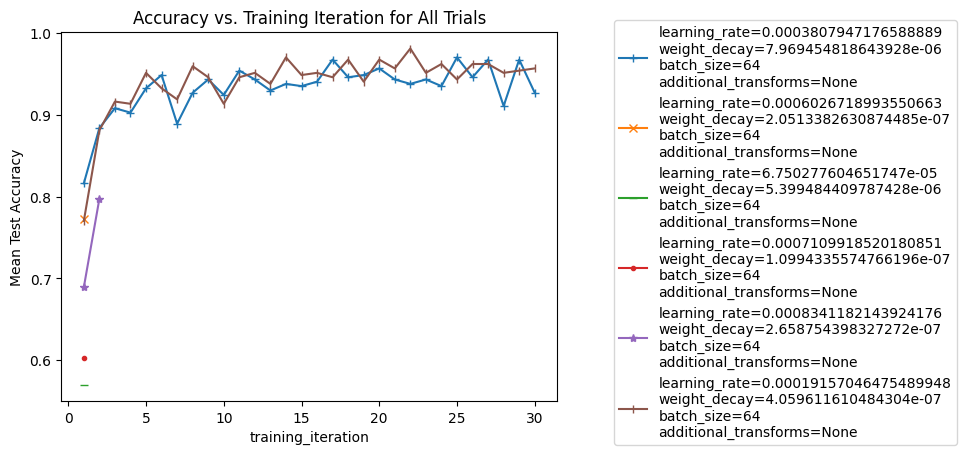

In [40]:
import matplotlib

def marker(i):
  marker = list("+x_.*|")
  return marker[i%len(marker)]

def plot_result(results, hyper_params):
  ax = None
  for idx, result in enumerate(results):
      label = "\n".join([f"{hyper_param}={result.config['train_loop_config'][hyper_param]}"
                        for hyper_param in hyper_params])
      if ax is None:
          ax = result.metrics_dataframe.plot("training_iteration", "val/accuracy_epoch", label=label, marker=marker(idx))
      else:
          result.metrics_dataframe.plot("training_iteration", "val/accuracy_epoch", ax=ax, label=label, marker=marker(idx))
  ax.set_title("Accuracy vs. Training Iteration for All Trials")
  ax.set_ylabel("Mean Test Accuracy")
  ax.legend(bbox_to_anchor=(1.1, 1.05))
  return ax

ax = plot_result(results, ['learning_rate', 'weight_decay', 'batch_size', 'additional_transforms'])

In [41]:
ax.figure.savefig("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt/hyperparameter_tuning3.png")

# Testing

In [42]:
def get_best_model():
  best_result = results.get_best_result("val/accuracy_epoch", mode="max")
  with best_result.checkpoint.as_directory() as checkpoint_dir:
      path = Path(checkpoint_dir) / "checkpoint"
      return path
t = get_best_model()

In [43]:
_, tr_train, tr_val = get_resnext50_model_and_transforms(num_classes)
classifier = Classifier.load_from_checkpoint(t)

In [44]:
dm = load_data(ds, tr_train, tr_val)

Found the following classes: ['Brick 1 x 2', 'Brick 2 x 2 Corner', 'Brick 2 x 6', 'Brick Arch 1 x 3 x 2 Inverted [Inside Bow]', 'Brick Arch 1 x 4 x 2', 'Brick Arch 1 x 6 x 2 - Thin Top without Reinforced Underside [New Version]', 'Brick Curved 2 x 3 with Curved Top', 'Brick Round 2 x 2 with Pin Holes', 'Brick Special 1 x 1 with Clip Horizontal', 'Fence Spindled 1 x 4 x 2 [4 Top Studs]', 'Hinge Brick 2 x 2 Locking with 2 Fingers Vertical and Axle Hole, 9 Teeth', 'Large Figure Skeletal, Limb, 5L with Ball Joint on Axle and Ball Socket', 'Plate 2 x 6', 'Plate 3 x 3 Cross', 'Plate Round 1 x 1 with Hollow Stud and Horizontal Bar 1L', 'Plate Special 1 x 2 with Handles on Ends', 'Plate Special Round 2 x 2 with Center Stud (Jumper Plate)', 'Slope 18° 4 x 1', 'Technic Axle and Pin Connector Angled #5 - 112.5°', 'Technic Axle and Pin Connector Perpendicular Double', 'Technic Beam 1 x 3 Thick', 'Technic Beam 1 x 4 Thin', 'Technic Beam 1 x 5 Thick', 'Technic Beam 1 x 7 Bent (4 - 4) Thick', 'Techni

In [46]:
trainer = Trainer()
test_result = trainer.test(model=classifier, dataloaders=dm)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/accuracy_epoch    │    0.9752475023269653     │
│      test/loss_epoch      │    0.07369040697813034    │
└───────────────────────────┴───────────────────────────┘

In [48]:
print(f"Test accuracy: {test_result[0]['test/accuracy_epoch']}")

Test accuracy: 0.9752475023269653


# Future Ideas

* Try other models
* Tune hyper parameters
* Use more data
* Deploy Web/Mobile App